# Setup & Predefined Fuctions

In [1]:
#!sudo apt update
#!sudo apt install -y mesa-utils

**First_Stage_Model: VAE**   # print(model.first_stage_model.encoder(torch.rand(1,3,512,512).to(device)).shape) #// encode->distribution
**Cond_stage_model: ClipEmbedder** # print(model.cond_stage_model("prompt").shape)  
**Init Latnet: Z_0 not Z_T** # samples=init_latent, x_samples = model.decode_first_stage(samples)


# Parameter Setting for Checkpoint and Config

In [2]:
import os
import PIL
import torch
import numpy as np
from omegaconf import OmegaConf
from PIL import Image
from itertools import islice
from einops import rearrange, repeat
from torch import autocast
from pytorch_lightning import seed_everything
import cv2
import time
from ldm.util import instantiate_from_config, load_model_from_config
from ldm.models.diffusion.ddim import DDIMSampler
from ldm.models.diffusion.dpm_solver import DPMSolverSampler
    
opt = {
    "cross_domain": False,
    "seed": 3407,
    "ckpt": "v2-1_512-ema-pruned.ckpt",
    "config": "./configs/stable-diffusion/v2-inference.yaml",
    "scale": 2.5,
    "n_samples": 1,
    "f": 16,
    "C": 4,
    "ddim_eta": 0.0,
    "ddim_steps": 20,
    "outdir": "./outputs/",
    "tau_a": 1,
    "tau_b": 1,
}

config = OmegaConf.load(opt["config"])
model = load_model_from_config(config, opt["ckpt"])    
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = model.to(device)
sampler = DPMSolverSampler(model)
outpath = opt["outdir"]
# Sampler->diffusion wrapper->DDPM

/home/machine1/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading model from v2-1_512-ema-pruned.ckpt
Global Step: 220000
No module 'xformers'. Proceeding without it.
LatentDiffusion: Running in eps-prediction mode
Diffusion Wrapper/Conditional key crossattn
<class 'ldm.modules.diffusionmodules.openaimodel.UNetModel'>
Diffusion Wrapper/diffusion model None
DiffusionWrapper has 865.91 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels


# Parameter Setting for Inputs

In [3]:
#opt["init_img"] = "./inputs/cross_domain/a pencil drawing of an eiffel tower in the distance, black and white painting/bg48.png"
"""
opt["ref_1_img"] = "./inputs/test/godzilla.png"
opt["ref_2_img"] = "./inputs/test/bigwave.png"
opt["composite_img"] = "./inputs/test/godzilla_bigwave.png"
"""
"""
opt["ref_1_img"] = "./inputs/test/judago_4.jpg"
opt["ref_2_img"] = "./inputs/test/winable.jpg"
opt["composite_img"] = "./inputs/test/judago_winable_3.jpg"
"""
opt["ref_1_img"] = "./inputs/test/kangaroo.jpg"
opt["ref_2_img"] = "./inputs/test/starry_night.jpg"
opt["composite_img"] = "./inputs/test/kangaroo_starry.jpg"

opt["prompt"] = ""
opt["ddim_steps"] = 20

# the object and background are from different domains
opt["cross_domain"] = True 
opt["scale"] = 5.0
# ORDER=1 : DDIM
ORDER = 2
# ORDER=2: DPM ++

SCALE=1

seed_everything(opt["seed"])
batch_size = opt["n_samples"]
prompt = opt["prompt"]
precision_scope = autocast

Global seed set to 3407


# Read Background and Foreground Images

In [4]:
from ldm.util import load_img
# read background image
ref_1_image, target_width, target_height = load_img(opt["ref_1_img"],SCALE)
ref_1_image = repeat(ref_1_image.to(device), '1 ... -> b ...', b=batch_size)

ref_2_image, width, height= load_img(opt["ref_2_img"], SCALE)
ref_2_image = repeat(ref_2_image.to(device), '1 ... -> b ...', b=batch_size)

composite_image, width, height= load_img(opt["composite_img"], SCALE)
composite_image = repeat(composite_image.to(device), '1 ... -> b ...', b=batch_size)

loaded input image of size (768, 1024) from ./inputs/test/kangaroo.jpg
resize input image of size (768, 1024) to 512, 512
loaded input image of size (1200, 950) from ./inputs/test/starry_night.jpg
resize input image of size (1200, 950) to 512, 512
loaded input image of size (1030, 901) from ./inputs/test/kangaroo_starry.jpg
resize input image of size (1030, 901) to 512, 512


# Image Reconstruction

In [5]:
from ldm.util import load_model_and_get_prompt_embedding
with torch.no_grad():
    with precision_scope("cuda"):
            print(prompt)
            c, uc, inv_emb = load_model_and_get_prompt_embedding(model, opt, device, prompt, inv=True)
            print("Condition shape", c.shape,uc.shape,inv_emb.shape)

            T1 = time.time()
            ref_1_latent = model.get_first_stage_encoding(model.encode_first_stage(ref_1_image))
            ref_2_latent = model.get_first_stage_encoding(model.encode_first_stage(ref_2_image))
            composite_latent = model.get_first_stage_encoding(model.encode_first_stage(composite_image))
            shape = ref_1_latent.shape[1:]
            z_ref_1_enc, _ = sampler.sample(steps=opt["ddim_steps"],
                                    inv_emb=inv_emb,
                                    unconditional_conditioning=uc,
                                    conditioning=c,
                                    batch_size=opt["n_samples"],
                                    shape=shape,
                                    verbose=False,
                                    unconditional_guidance_scale=opt["scale"],
                                    eta=opt["ddim_eta"],
                                    order=ORDER,
                                    x_T=ref_1_latent,
                                    width=width,
                                    height=height,
                                    DPMencode=True,
                                    )
            
            z_ref_2_enc, _ = sampler.sample(steps=opt["ddim_steps"],
                                        inv_emb=inv_emb,
                                        unconditional_conditioning=uc,
                                        conditioning=c,
                                        batch_size=opt["n_samples"],
                                        shape=shape,
                                        verbose=False,
                                        unconditional_guidance_scale=opt["scale"],
                                        eta=opt["ddim_eta"],
                                        order=ORDER,
                                        x_T=ref_2_latent,
                                        DPMencode=True,
                                        width=width,
                                        height=height,
                                        ref=True,
                                        )
            z_composite_enc, _ = sampler.sample(steps=opt["ddim_steps"],
                                        inv_emb=inv_emb,
                                        unconditional_conditioning=uc,
                                        conditioning=c,
                                        batch_size=opt["n_samples"],
                                        shape=shape,
                                        verbose=False,
                                        unconditional_guidance_scale=opt["scale"],
                                        eta=opt["ddim_eta"],
                                        order=ORDER,
                                        x_T=composite_latent,
                                        DPMencode=True,
                                        width=width,
                                        height=height,
                                        ref=True,
                                        )
                        
            samples = sampler.sample(steps=opt["ddim_steps"],
                                        inv_emb=torch.cat([inv_emb,inv_emb,inv_emb]),
                                        conditioning=torch.cat([c,c,c]),
                                        shape=shape,
                                        verbose=False,
                                        unconditional_guidance_scale=opt["scale"],
                                        unconditional_conditioning=torch.cat([uc,uc,uc]),
                                        eta=opt["ddim_eta"],
                                        order=ORDER,
                                        x_T=torch.cat([z_ref_1_enc,z_ref_2_enc,z_composite_enc]),
                                        width=width,
                                        height=height,
                                        )
                
            x_reconstruct = model.decode_first_stage(samples)
            x_reconstruct = torch.clamp((x_reconstruct + 1.0) / 2.0, min=0.0, max=1.0)
            
            T2 = time.time()
            print('Running Time: %s s' % ((T2 - T1)))
names=["ref_1_recon.png","ref_2_recon.png","composite_recon.png"]
sample_path="./outputs/tfphd"
for x_sample,sample_name in zip(x_reconstruct,names):
    x_sample = 255. * rearrange(x_sample.cpu().numpy(), 'c h w -> h w c')
    img = Image.fromarray(x_sample.astype(np.uint8))
    img.save(os.path.join(sample_path, sample_name))


inv_emb for
Get_learned_conditioning (exceptional )
uc for
Get_learned_conditioning (exceptional )
c for
Get_learned_conditioning (exceptional )
Condition shape torch.Size([1, 77, 1024]) torch.Size([1, 77, 1024]) torch.Size([1, 77, 1024])
DDPM/get_first_stage_encoding: DiagonalGaussianDistribution
DDPM/get_first_stage_encoding: DiagonalGaussianDistribution
DDPM/get_first_stage_encoding: DiagonalGaussianDistribution


DPM++ inversion (adding noise) Z0-->ZT: 100%|██████████| 19/19 [00:01<00:00, 12.70it/s]


DPM_solver x.shape: torch.Size([3, 4, 64, 64])


DPM++ sampling (denoising) ZT-->Z0: 100%|██████████| 19/19 [00:03<00:00,  5.22it/s]


sample finishe torch.Size([3, 4, 64, 64])
Running Time: 10.022781610488892 s


# TFPHD Harmonization

Create hijack attention
MasaCtrl at denoising steps:  [18, 19]
MasaCtrl at U-Net layers:  [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Rescales= tensor([0.8000, 1.2000], device='cuda:0')
Editor --> 32
DPM_solver x.shape: torch.Size([3, 4, 64, 64])


DPM++ sampling (denoising) ZT-->Z0: 100%|██████████| 19/19 [00:04<00:00,  4.59it/s]


sample finishe torch.Size([3, 4, 64, 64])


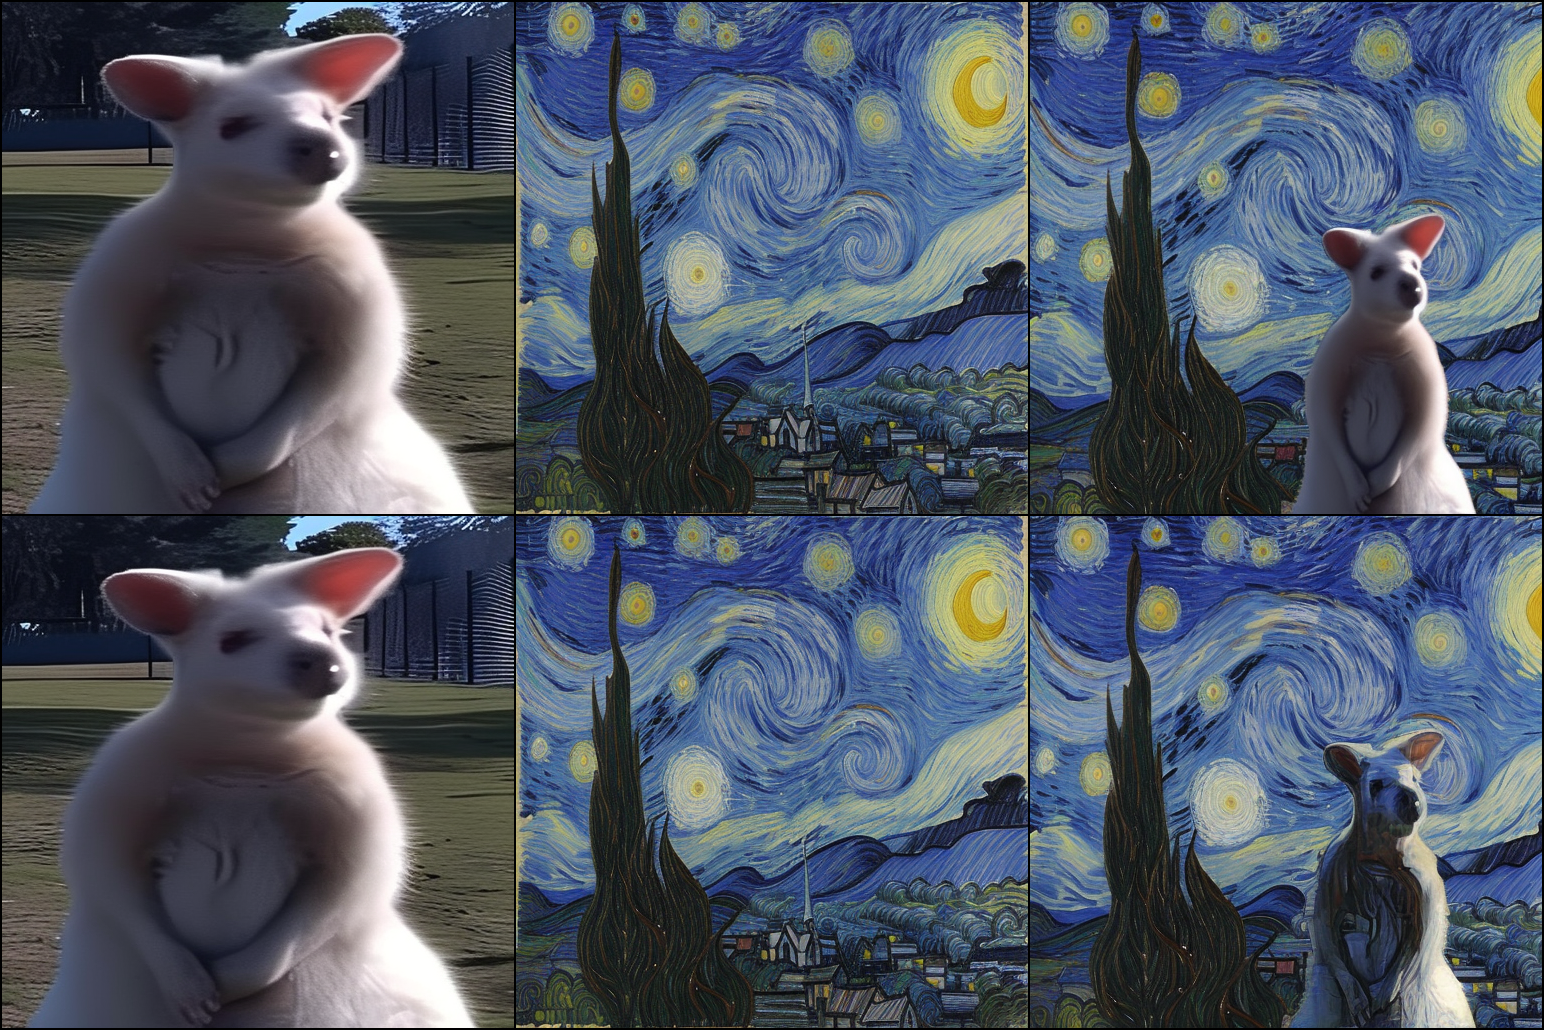

In [6]:

#from masactrl.masactrl_utils import AttentionBase
from attention_control.masactrl_utils import regiter_attention_editor_ldm
from attention_control.share_attention import ShareSelfAttentionControl
from torchvision.utils import save_image
import IPython
###
STEP = int(opt["ddim_steps"]*0.9)
LAYER = 4
#ref_scales = torch.tensor([0.8,2]).to(device) # Style
sim_scales = torch.tensor([0.8,1.2]).to(device) # Realistic
###

with precision_scope("cuda"):
    # hijack the attention module (sclaed share)
    editor = ShareSelfAttentionControl(STEP, LAYER,scales=sim_scales,total_steps=opt["ddim_steps"])
    regiter_attention_editor_ldm(model, editor)
    latents_harmonized = sampler.sample(steps=opt["ddim_steps"],
                                inv_emb=torch.cat([inv_emb,inv_emb,inv_emb]),
                                conditioning=torch.cat([c,c,c]),
                                shape=shape,
                                verbose=False,
                                unconditional_guidance_scale=opt["scale"],
                                unconditional_conditioning=torch.cat([uc,uc,uc]),
                                eta=opt["ddim_eta"],
                                order=ORDER,
                                x_T=torch.cat([z_ref_1_enc,z_ref_2_enc,z_composite_enc]),
                                width=width,
                                height=height,
                                )
    x_harmonized = model.decode_first_stage(latents_harmonized)
    x_harmonized = torch.clamp((x_harmonized + 1.0) / 2.0, min=0.0, max=1.0)
names=["ref_1_harmonized.png","ref_2_harmonized.png","composite_harmonized.png"]
sample_path="./outputs/tfphd"
for x_sample,sample_name in zip(x_harmonized,names):
    x_sample = 255. * rearrange(x_sample.cpu().numpy(), 'c h w -> h w c')
    img = Image.fromarray(x_sample.astype(np.uint8))
    img.save(os.path.join(sample_path, sample_name))

composite_name=opt["composite_img"].split("/")[-1][:-4]
file_name=os.path.join(sample_path, f"{composite_name}_{STEP}_{LAYER}_total.png")
save_image(torch.cat([x_reconstruct,x_harmonized]), file_name,nrow=3)
IPython.display.Image(filename=file_name)